Connected to spyice (Python 3.12.6)

In [ ]:
import math

import matplotlib.pyplot as plt

# TODO: check if the concentration is dependent on previous iterations or vice-versa
# TODO: implement mushy layer consideration with liquid fraction check paper
import numpy as np
import scipy.optimize as opt

from src.spyice.parameters.user_input import UserInput

ui = UserInput()


class StefanProblem:
    """A class to solve the Stefan problem."""

    @staticmethod
    def stefan_problem(t, ui: UserInput):
        """Calculates the Stefan problem solution for a given time and user input.

        Args:
            t (float): The time value.
            ui (UserInput): An instance of the UserInput class containing the necessary input parameters.

        Returns:
            float: The calculated Stefan problem solution.

        Raises:
            None

        """
        # Rest of the code...
        stefan_number = (
            ui.constants.c_i
            * (ui.temperature_melt - ui.boundary_top_temperature)
            / ui.constants.L
        )
        fx = (  # noqa: E731
            lambda x: stefan_number * np.exp(-(x**2)) / (np.sqrt(np.pi) * math.erf(x))
            - x
        )

        dfxdx = lambda x: (  # noqa: E731
            -2 * stefan_number * np.exp(-(x**2)) * x / (np.sqrt(np.pi) * math.erf(x))
            - 2 * stefan_number * np.exp(-2 * x**2) / (np.pi * math.erf(x) ** 2)
            - 1
        )
        lam_min = opt.newton(fx, 0.1, fprime=dfxdx, tol=0.0003, maxiter=100)
        alpha = ui.constants.k_i / (ui.constants.c_i * ui.constants.rho_i)
        return 2 * lam_min * np.sqrt(alpha * t)

    @staticmethod
    def calculate_temperature_profile(depth_stefan, t, dz, nz, ui: UserInput):
        # sourcery skip: chain-compares
        """Calculates the temperature profile for the Stefan problem.

        Args:
            depth_stefan (float): The depth of the Stefan problem.
            t (float): The time.
            dz (float): The step size in the z-direction.
            nz (int): The number of grid points in the z-direction.
            ui (UserInput): An instance of the UserInput class containing the required constants and parameters.

        Returns:
            numpy.ndarray: An array containing the temperature profile for the Stefan problem.
        """
        ...
        alpha = ui.constants.k_i / (ui.constants.c_i * ui.constants.rho_i)
        nz_depth = int(np.absolute(depth_stefan) / dz)
        z = np.linspace(0, np.absolute(depth_stefan), nz_depth)
        temperature_stefan = np.ones(nz) * ui.temperature_melt
        if (np.absolute(depth_stefan) != nz_depth) and (nz_depth != 0):
            for i in range(nz_depth):
                erf_values = math.erf(z[i] / (2 * np.sqrt(alpha * t)))
                erf_depth = math.erf(depth_stefan / (2 * np.sqrt(alpha * t)))
                temperature_stefan[i] = ui.boundary_top_temperature - (
                    ui.boundary_top_temperature - ui.temperature_melt
                ) * (erf_values / erf_depth)
        return temperature_stefan

    @staticmethod
    def calculate_temperature_twophase_profiles(depth_stefan, t, dz, nz, ui: UserInput=UserInput()):
        """Calculate the temperature and salinity profiles for the Stefan problem in a two-phase system.

        Args:
            depth_stefan (float): The depth of the Stefan problem.
            t (float): The time.
            dz (float): The grid spacing.
            nz (int): The number of grid points.
            ui (UserInput): An instance of the UserInput class containing the input parameters.

        Returns:
            tuple: A tuple containing the temperature and salinity profiles as numpy arrays.
        """
        # Function implementation goes here
        # pass
        nz_depth = int(np.absolute(depth_stefan) / dz)
        z = np.linspace(0, np.absolute(depth_stefan), nz_depth)
        temperature = np.ones(nz) * ui.temperature_melt
        salinity = np.ones(nz)*ui.boundary_salinity
        eta = z / np.sqrt(4 * ui.constants.D_s * t)
        temperature_boundary = ui.boundary_top_temperature
        temperature_bottom = ui.temperature_melt
        eps = lambda k: np.sqrt(ui.constants.D_s / k)  # noqa: E731
        kappa_i = ui.constants.k_i / (ui.constants.rho_i * ui.constants.c_i)
        kappa_br = ui.constants.k_br / (ui.constants.rho_br * ui.constants.c_br)
        f_x = lambda x: np.pi ** (1 / 2) * x * np.exp(x**2) * math.erfc(x)  # noqa: E731
        s_fi = lambda lamb: ui.boundary_salinity * f_x(lamb) / (1 - f_x(lamb))  # noqa: E731
        salinity_constant = ui.boundary_salinity + s_fi(depth_stefan)
        temperature_interface = ui.temperature_melt - 1.853 * salinity_constant / 28.0

        for i in range(nz_depth):
            erf_values_solid = math.erf(eps(kappa_i) * eta[i])
            erf_depth_solid = math.erf(eps(kappa_i) * depth_stefan)
            erfc_values_liquid = math.erfc(eps(kappa_br) * eta[i])
            erfc_depth_liquid = math.erfc(eps(kappa_br) * depth_stefan)

            if eta[i] < depth_stefan and (i< nz):
                temperature[i] = temperature_boundary + (
                    temperature_interface - temperature_boundary
                ) * (erf_values_solid / erf_depth_solid)
                salinity[i] = salinity[i]
            elif eta[i] >= depth_stefan and (i< nz):
                temperature[i] = temperature_bottom + (
                    temperature_interface - temperature_bottom
                ) * (erfc_values_liquid / erfc_depth_liquid)
                salinity[i] = ui.boundary_salinity
                + (salinity_constant - ui.boundary_salinity) * math.erfc(eta[i]) / math.erfc(depth_stefan)
            else:
                pass

            # salinity[i] = np.where(
            #     eta >= depth_stefan,
            #     ui.boundary_salinity
            #     + (salinity - ui.boundary_salinity) * math.erfc(eta) / math.erfc(depth_stefan),
            #     salinity[:nz_depth],
            # )
        return np.array(temperature), np.array(salinity)

    @staticmethod
    def stefan_problem_twophase(t, ui: UserInput=UserInput()):
        """Solves the Stefan problem for a two-phase system.

        Args:
            t (float): Time parameter.
            ui (UserInput): User input object containing boundary conditions and constants.
        Returns:
            float: The result of the Stefan problem calculation.
        """
        # Rest of the code...

        gamma = 1.853 / 28.0
        s_0 = ui.boundary_salinity
        f_x = lambda x: np.pi ** (1 / 2) * x * np.exp(x**2) * math.erfc(x)  # noqa: E731
        g_x = lambda x: np.pi ** (1 / 2) * x * np.exp(x**2) * math.erf(x)  # noqa: E731
        eps = lambda k: np.sqrt(ui.constants.D_s / k)  # noqa: E731
        temperature_boundary = ui.boundary_top_temperature
        temperature_bottom = ui.temperature_melt
        t_l = ui.temperature_melt - gamma * s_0
        temperature_diff = t_l - temperature_boundary
        t_0 = temperature_bottom - t_l
        kappa_i = ui.constants.k_i / (ui.constants.rho_i * ui.constants.c_i)
        kappa_br = ui.constants.k_br / (ui.constants.rho_br * ui.constants.c_br)
        beta = (
            ui.constants.rho_br
            * ui.constants.c_br
            / (ui.constants.rho_i * ui.constants.c_i)
        )
        s_fi = lambda lamb: gamma * s_0 * f_x(lamb) / (1 - f_x(lamb))  # noqa: E731
        root_fx_lhs = lambda lamb: s_fi(lamb) * (  # noqa: E731
            beta / f_x(eps(kappa_br) * lamb) + 1 / g_x(eps(kappa_i) * lamb)
        )
        root_fx_rhs = (  # noqa: E731
            lambda lamb: temperature_diff / g_x(eps(kappa_i) * lamb)
            - beta * t_0 / f_x(eps(kappa_br) * lamb)
            - ui.constants.L / ui.constants.c_i
        )
        # FIXME: root_fx_rhs(lamb) results in -> -inf for lamb in -ve range
        root_fx = lambda lamb: root_fx_lhs(lamb) - root_fx_rhs(lamb)  # noqa: E731
        lambda_stefan = opt.newton(root_fx, 0.1, tol=1e-3, maxiter=100)  # TODO: why is starting point 0.1?
        
        return 2 * lambda_stefan * np.sqrt(ui.constants.D_s * t)  # TODO: check the units of D_s and t


@staticmethod
def _plot_stefan_temp_twophase(z_depth=0.1):
    dt = ui.grid_timestep_dt
    t_passed = 0
    temperature_array = []
    salinity_arr = []
    t_pass_arr = []
    depth_stefan_arr = []
    Z = 1
    nc = int(Z / ui.grid_resolution_dz)
    nz = int(nc + 1)
    for t in range(ui.max_iterations):
        t_passed += dt 
        depth_stefan = StefanProblem.stefan_problem_twophase(t_passed)
        if t > 0:
            T, C = StefanProblem.calculate_temperature_twophase_profiles(depth_stefan, t, ui.grid_resolution_dz, nz)
        else: 
            T, C = np.ones(nz) * ui.temperature_melt , np.ones(nz) * ui.boundary_salinity
        depth_stefan_arr.append(depth_stefan)
        temperature_array.append(T)
        salinity_arr.append(C)
        t_pass_arr.append(t_passed)
    z = int(z_depth * nz)
    temperature_array = np.array(temperature_array)
    T_z = temperature_array[:, z]
    plt.grid()
    plt.plot(np.array(t_pass_arr) / 3600, T_z, label="Temperature")
    plt.xlabel("Time in h")
    plt.ylabel("Temperature")
    plt.show()
    return temperature_array, salinity_arr


In [2]:
stefan = StefanProblem()

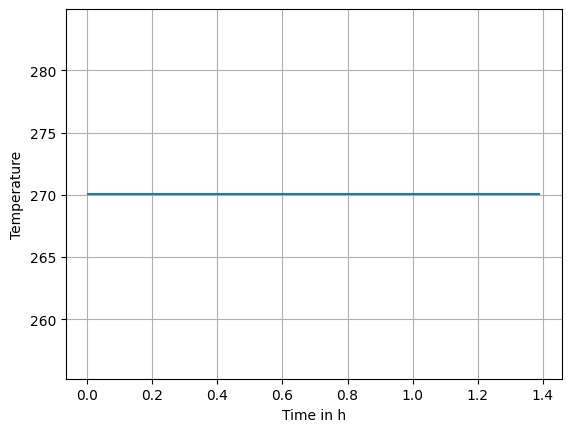

In [3]:
t_arr, s_arr = _plot_stefan_temp_twophase()

In [ ]:
t_arr_0p1, s_arr_0p1 = _plot_stefan_temp_twophase(z_depth=0.001)